In [1]:
import rosbag
import params.robot

import pandas as pd
import numpy as np
import traversalcost.utils
from tqdm import tqdm

from matplotlib import pyplot as plt

from params import PROJECT_PATH

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Visualize formulas

## Waibel et al. (2022)

In [3]:
from functools import lru_cache

@lru_cache
def get_roll_pitch_vertical_acceleration_lists(bagfile: str):
    """
    Notes:
        The function is cached in order to avoid reading the same bagfile multiple times.
        (reading a bagfile is a slow operation)
    """
    bag = rosbag.Bag(bagfile)
    messages = list(bag.read_messages(topics=[params.robot.IMU_TOPIC]))

    roll_list = [msg.message.angular_velocity.x for msg in messages]
    pitch_list = [msg.message.angular_velocity.y for msg in messages]
    vertical_acceleration_list = [msg.message.linear_acceleration.z - 9.81 for msg in messages]
    
    return roll_list, pitch_list, vertical_acceleration_list


# Compute max of roll, pitch and vertical acceleration
max_roll = -np.inf
max_pitch = -np.inf
max_vertical_acceleration = -np.inf

csv_labels = PROJECT_PATH / "src/traversal_cost/datasets/dataset_all_terrain/labels.csv"
labels_df = pd.read_csv(csv_labels, converters={"id": str})

for file in tqdm(labels_df["file"].unique()):
    roll_list, pitch_list, vertical_acceleration_list = get_roll_pitch_vertical_acceleration_lists(PROJECT_PATH / file)

    max_roll = max(max_roll, np.max(roll_list))
    max_pitch = max(max_pitch, np.max(pitch_list))
    max_vertical_acceleration = max(max_vertical_acceleration, np.max(vertical_acceleration_list))

100%|██████████| 14/14 [00:59<00:00,  4.25s/it]


In [4]:
max_roll, max_pitch, max_vertical_acceleration

(1.782672643661499, 2.281592845916748, 49.54992431640625)

In [5]:
def get_traversal_cost_waibel(roll_list, pitch_list, vertical_acceleration_list):
    """
    Calculates the traversal cost as defined by Waibel et al. (2022).
    """
    data = np.array([roll_list, pitch_list, vertical_acceleration_list])
    data = np.abs(data)

    # Normalize data (with hypothesis of min = 0)
    data /= np.array([
        [max_roll],
        [max_pitch],
        [max_vertical_acceleration],
    ])
    
    return np.mean(data)

In [6]:
def get_traversal_cost_single_row(row: pd.Series, get_traversal_cost) -> float:
    start_idx, end_idx = row["start_index"], row["end_index"]
    roll_list, pitch_list, vertical_acceleration_list = get_roll_pitch_vertical_acceleration_lists(PROJECT_PATH / row["file"])

    return get_traversal_cost(
        roll_list[start_idx:end_idx],
        pitch_list[start_idx:end_idx],
        vertical_acceleration_list[start_idx:end_idx]
    )

def get_traversal_cost_df(csv_labels: str, get_traversal_cost) -> pd.DataFrame:
    labels_df = pd.read_csv(csv_labels, converters={"id": str})
    
    cost_df = pd.DataFrame()
    cost_df["terrain_class"] = labels_df["terrain_class"]
    cost_df["linear_velocity"] = labels_df["linear_velocity"]

    cost_df["cost"] = labels_df.apply(
        get_traversal_cost_single_row,
        axis=1,
        get_traversal_cost=get_traversal_cost
    )
    
    return cost_df

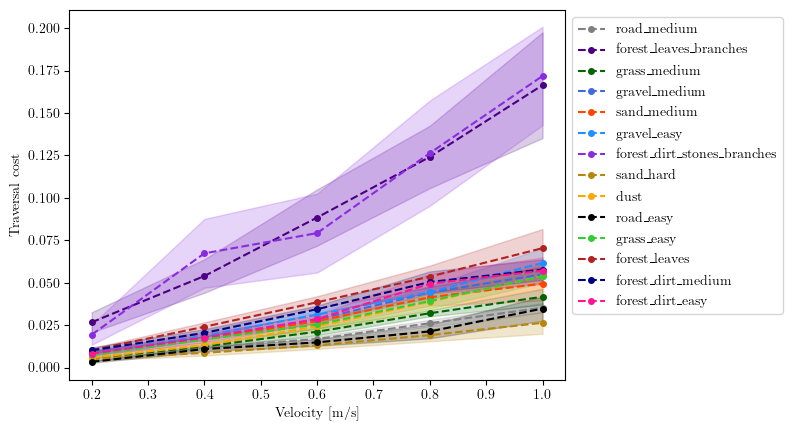

In [7]:
cost_df = get_traversal_cost_df(csv_labels, get_traversal_cost_waibel)
traversalcost.utils.display_confidence_intervals(cost_df);

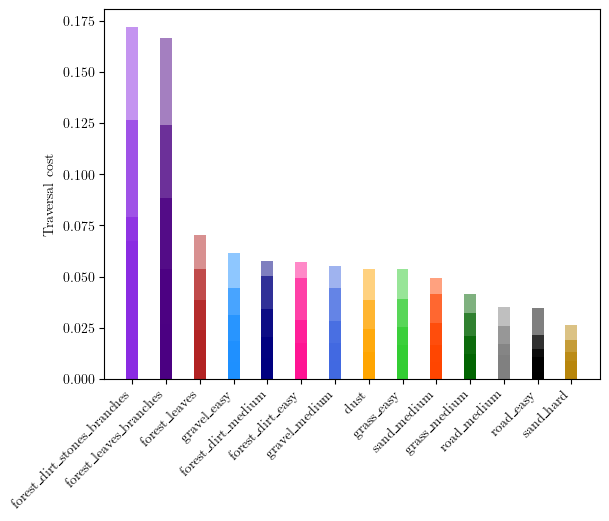

In [8]:
traversalcost.utils.display_traversal_cost_order(cost_df);

## Siamese

In [9]:
cost_df = pd.read_csv(PROJECT_PATH / "src/traversal_cost/siamese_network/logs/_2023-09-27-12-22-04/costs_df.csv", index_col=0)
cost_df

,terrain_class,linear_velocity,cost
0,grass_easy,0.2,2.332287
1,grass_easy,0.2,2.295089
2,grass_easy,0.2,2.279682
3,grass_easy,0.2,2.335167
4,grass_easy,0.2,2.312038
...,...,...,...
1255,sand_hard,1.0,2.804955
1256,sand_hard,1.0,4.190214
1257,sand_hard,1.0,4.353060
1258,sand_hard,1.0,3.190498


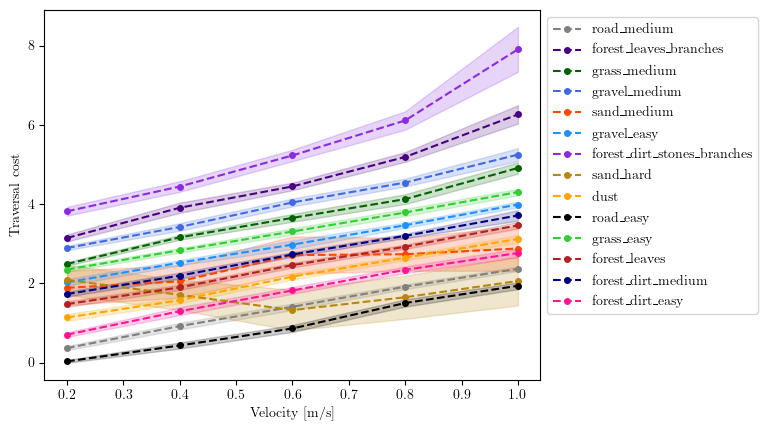

In [10]:
traversalcost.utils.display_confidence_intervals(cost_df);

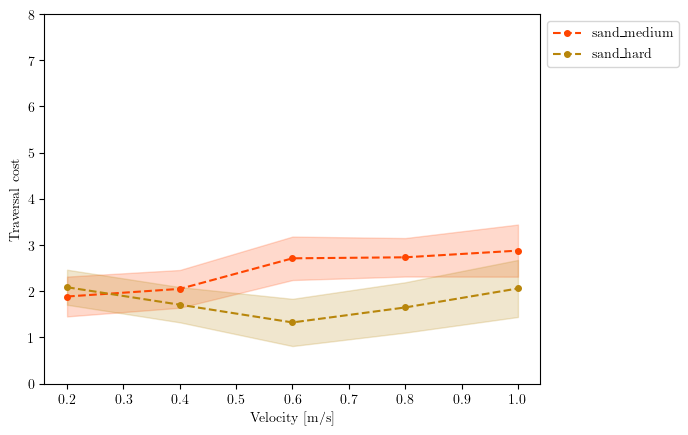

In [11]:
traversalcost.utils.display_confidence_intervals(cost_df[cost_df["terrain_class"].isin(["sand_medium", "sand_hard"])])
plt.ylim(0, 8);

## BADGR

In [12]:
def get_traversal_cost_badgr(roll_list, pitch_list, _):
    """
    Calculates the traversal cost as defined by Kahn et al. (2021).
    """
    data = np.array([roll_list, pitch_list])
    data = np.abs(data)

    return np.mean(data)

## Guo et al. (2011)

In [13]:
def get_traversal_cost_guo(roll_list, pitch_list, _):
    """
    Calculates the traversal cost as defined by Guo et al. (2011).
    """
    data = np.array([roll_list, pitch_list])
    # compute derivative of roll and pitch
    data = np.diff(data, axis=1)
    data = np.std(data, axis=1)

    return np.mean(data)

## Bekhti

In [14]:
def get_traversal_cost_bekhti(_, __, vertical_acceleration_list):
    """
    Calculates the traversal cost as defined by Bekhti et al. (2020).
    """
    data = np.abs(vertical_acceleration_list)

    return np.mean(data)

## All

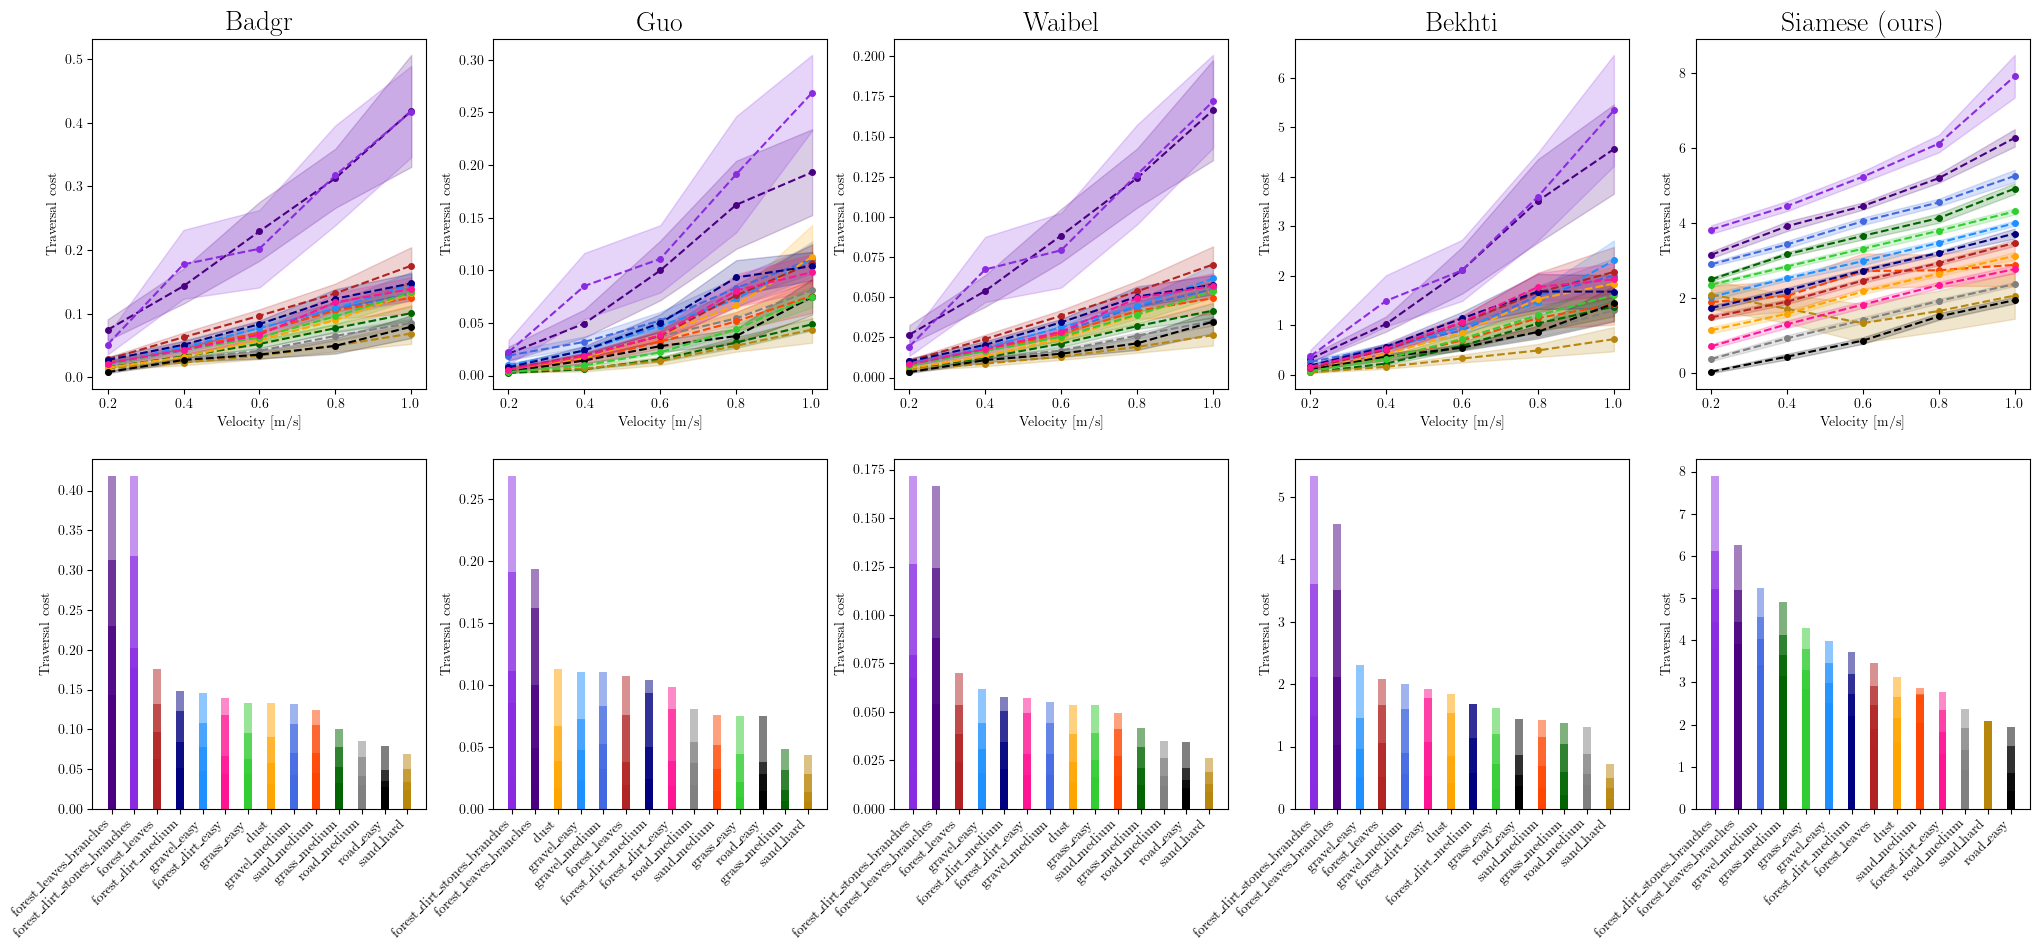

In [16]:
cost_function_list = [get_traversal_cost_badgr, get_traversal_cost_guo, get_traversal_cost_waibel, get_traversal_cost_bekhti]
function_name_list = ["Badgr", "Guo", "Waibel", "Bekhti"]

# +1 = siamese approach
nb_cost_functions = len(cost_function_list) + 1
plt.figure(figsize=(5*nb_cost_functions, 5*2))

for i, (cost_function, function_name) in enumerate(zip(cost_function_list, function_name_list), start=1):
    cost_df = get_traversal_cost_df(csv_labels, cost_function)

    plt.subplot(2, nb_cost_functions, i)
    plt.title(function_name, fontsize=20)
    traversalcost.utils.display_confidence_intervals(cost_df, no_legend=True)

    plt.subplot(2, nb_cost_functions, i + nb_cost_functions)
    traversalcost.utils.display_traversal_cost_order(cost_df)
    
# Siamese approach
cost_df = pd.read_csv(PROJECT_PATH / "src/traversal_cost/siamese_network/logs/_2023-09-27-12-22-04/costs_df.csv", index_col=0)
plt.subplot(2, nb_cost_functions, nb_cost_functions)
plt.title("Siamese (ours)", fontsize=20)
traversalcost.utils.display_confidence_intervals(cost_df, no_legend=True)

plt.subplot(2, nb_cost_functions, nb_cost_functions * 2)
traversalcost.utils.display_traversal_cost_order(cost_df)

plt.savefig("traversal_cost_benchmark.png");